In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import shap

In [2]:
# Load datasets
gen1_train = pd.read_csv('gen1_train_comp_final.csv')
gen2_train = pd.read_csv('gen2_train_comp_final.csv')
gen1_test = pd.read_csv('gen1_test_comp_final.csv')
gen2_test = pd.read_csv('gen2_test_upto9_comp_final.csv')
template = pd.read_csv('gen2_test_solution_template.csv')

## EDA

### Displaying dataset shapes

In [3]:
# Display dataset shapes
print("Dataset shapes:")
print(f"Gen1 Training: {gen1_train.shape}")
print(f"Gen2 Training: {gen2_train.shape}")
print(f"Gen1 Test: {gen1_test.shape}")
print(f"Gen2 Test: {gen2_test.shape}")

Dataset shapes:
Gen1 Training: (3636, 4)
Gen2 Training: (4224, 7)
Gen1 Test: (2232, 4)
Gen2 Test: (1232, 7)


### Displaying basic statistics

In [4]:
# Gen1 training statistics
print("Gen1 Training Data Columns:\n", gen1_train.columns.to_list(), "\n")
print("Gen1 Training Data Overview:\n", gen1_train.describe())

Gen1 Training Data Columns:
 ['gen1_id', 'sex_assigned_at_birth', 'age', 'SHgt_cm'] 

Gen1 Training Data Overview:
           gen1_id          age      SHgt_cm
count  3636.00000  3636.000000  3326.000000
mean    574.80198    10.350000   135.439189
std     114.14434     6.324272    38.831436
min     370.00000     0.100000    50.627457
25%     490.00000     4.750000   105.990771
50%     569.00000    11.250000   146.593052
75%     679.00000    15.625000   166.793640
max     774.00000    20.000000   197.081343


We only have age, height, and sex in the gen1 training set. The age feature ranges from .1 to 20 years.

In [5]:
# Gen2 training statistics
print("Gen2 Training Data Columns:\n", gen2_train.columns.to_list(), "\n")
print("Gen2 Training Data Overview:\n", gen2_train.describe())

Gen2 Training Data Columns:
 ['gen2_id', 'sex_assigned_at_birth', 'study_parent_sex', 'study_parent_id_new', 'AgeGr', 'SHgt_cm', 'Wgt_kg'] 

Gen2 Training Data Overview:
            gen2_id  study_parent_id_new        AgeGr      SHgt_cm       Wgt_kg
count  4224.000000          4224.000000  4224.000000  3712.000000  2179.000000
mean   2650.552083           556.604167     7.140909   118.697202    38.362150
std     139.645270           133.354678     5.646657    37.809589    16.880285
min    1332.000000           262.000000     0.100000    49.896709     4.636903
25%    2574.500000           453.250000     1.500000    83.766677    24.263125
50%    2648.500000           550.500000     6.500000   121.085655    34.270051
75%    2736.250000           668.000000    12.000000   151.367367    50.468043
max    3012.000000           774.000000    18.000000   196.140713   112.812058


Gen2 has the same features as gen1, as well as their weight and parent's id and sex. Age ranges from .1 to 18 years.

In [6]:
# Gen1 test statistics
print("Gen1 Test Data Columns:\n", gen1_test.columns.to_list(), "\n")
print("Gen1 Test Data Overview:\n", gen1_test.describe())

Gen1 Test Data Columns:
 ['gen1_id', 'sex_assigned_at_birth', 'age', 'SHgt_cm'] 

Gen1 Test Data Overview:
            gen1_id          age      SHgt_cm
count  2232.000000  2232.000000  2016.000000
mean    570.661290    10.350000   133.756496
std     114.745977     6.324819    38.298998
min     368.000000     0.100000    48.391836
25%     474.000000     4.750000   103.805282
50%     574.000000    11.250000   145.012864
75%     663.000000    15.625000   165.460237
max     768.000000    20.000000   192.558592


In the gen1 test set, we have the same features and age range.

In [7]:
# Gen2 test statistics
print("Gen2 Test Data Columns:\n", gen2_test.columns.to_list(), "\n")
print("Gen2 Test Data Overview:\n", gen2_test.describe())

Gen2 Test Data Columns:
 ['gen2_id', 'sex_assigned_at_birth', 'study_parent_sex', 'study_parent_id_new', 'AgeGr', 'SHgt_cm', 'Wgt_kg'] 

Gen2 Test Data Overview:
            gen2_id  study_parent_id_new        AgeGr      SHgt_cm      Wgt_kg
count  1232.000000          1232.000000  1232.000000  1100.000000  409.000000
mean   2674.340909           542.215909     3.435714    96.240499   24.205836
std     103.220902           131.443688     2.963793    25.654321    5.097179
min    2332.000000           274.000000     0.100000    49.772812   14.932562
25%    2594.250000           423.250000     0.750000    73.318169   20.279088
50%    2673.500000           530.000000     2.500000    95.548570   23.567309
75%    2762.500000           649.000000     6.000000   118.999817   27.337289
max    2831.000000           768.000000     9.000000   147.217952   46.443758


The age in the gen2 test set only ranges from .1 to 9 years, so we'll predict ages 10-18. The variables are the same as the training set.

### Missing data analysis

In [8]:
# Display missing data
print("Gen1 training missing data \n", gen1_train.isna().sum(), "\n")
print("Gen2 training missing data \n", gen2_train.isna().sum(), "\n")
print("Gen1 test missing data \n", gen1_test.isna().sum(), "\n")
print("Gen2 test missing data \n", gen2_test.isna().sum(), "\n")

Gen1 training missing data 
 gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  310
dtype: int64 

Gen2 training missing data 
 gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                   512
Wgt_kg                   2045
dtype: int64 

Gen1 test missing data 
 gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  216
dtype: int64 

Gen2 test missing data 
 gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                  132
Wgt_kg                   823
dtype: int64 



There is missing data in the height and weight columns. As height is missing in almost half of all records, it may make sense to simply drop the feature. We will impute the missing height values.

### Plotting growth patterns by sex

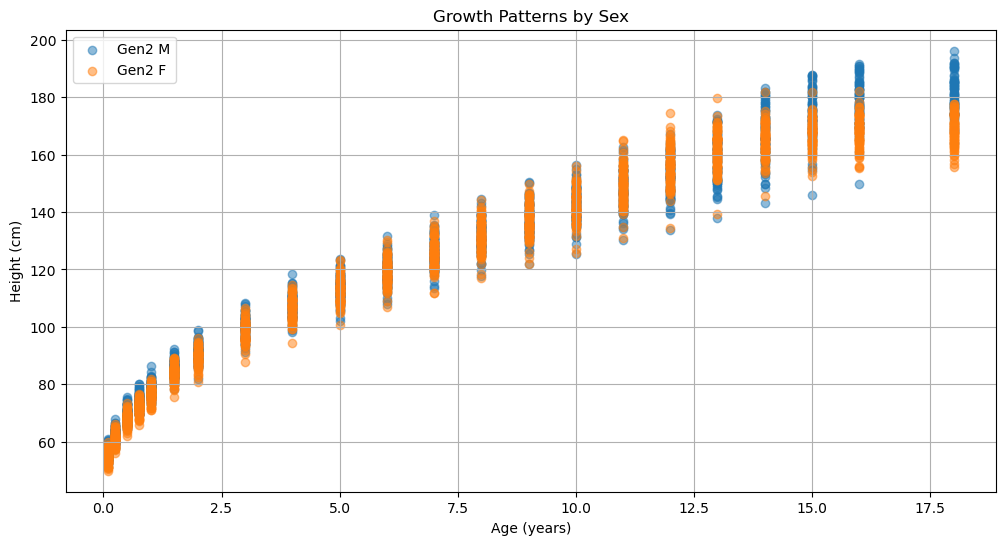

In [9]:
# Plot growth (age vs height) by sex for gen2
plt.figure(figsize=(12, 6))

for sex in gen2_train['sex_assigned_at_birth'].unique():
    data = gen2_train[gen2_train['sex_assigned_at_birth'] == sex]
    plt.scatter(data['AgeGr'], data['SHgt_cm'], 
               alpha=0.5, label=f'Gen2 {sex}')

plt.xlabel('Age (years)')
plt.ylabel('Height (cm)')
plt.title('Growth Patterns by Sex')
plt.legend()
plt.grid(True)
plt.show()

## Data processing and model training

In [10]:
# Group training data by id for subsequent processing
gen2_grouped = gen2_train.groupby('gen2_id')
gen1_grouped = gen1_train.groupby('gen1_id')

### Processing gen2 training data (creating features and dealing with missing values)

In [11]:
features_list = []

# Process each Gen2 individual in the training set
for gen2_id, group in gen2_grouped:
    # Sort each individual's data by age
    group = group.sort_values('AgeGr')
    
    # Get parent data if available
    parent_id = group['study_parent_id_new'].iloc[0]
    parent_data = gen1_grouped.get_group(parent_id) if parent_id in gen1_grouped.groups else None
    
    # Calculate early growth features (0-9 years)
    early_measurements = group[group['AgeGr'] <= 9]
    
    if len(early_measurements) >= 2:
        # Calculate growth velocities (take difference in height and age between consecutive measurements and divide)
        velocities = np.diff(early_measurements['SHgt_cm'].values) / \
                    np.diff(early_measurements['AgeGr'].values)
        
        # Calculate growth features (average of different age intervals)
        height_0_3 = early_measurements[early_measurements['AgeGr'] <= 3]['SHgt_cm'].mean()
        height_3_6 = early_measurements[(early_measurements['AgeGr'] > 3) & 
                                     (early_measurements['AgeGr'] <= 6)]['SHgt_cm'].mean()
        height_6_9 = early_measurements[(early_measurements['AgeGr'] > 6) & 
                                     (early_measurements['AgeGr'] <= 9)]['SHgt_cm'].mean()
        
        # Get parent features if available
        if parent_data is not None:
            # Get parent height as an adult (after age 18)
            parent_adult_height = parent_data[parent_data['age'] >= 18]['SHgt_cm'].mean()
            # Get parent growth pattern (mean height in different age intervals)
            parent_growth_pattern = np.array([
                parent_data[(parent_data['age'] >= a) & (parent_data['age'] < a + 3)]['SHgt_cm'].mean()
                for a in range(0, 19, 3)
            ])
        else:
            # Use -1 as a flag for missing parent data
            parent_adult_height = -1  
            parent_growth_pattern = np.full(7, -1)
        
        # Create feature dictionary
        features = {
            'gen2_id': gen2_id,
            'sex': group['sex_assigned_at_birth'].iloc[0],
            'parent_sex': group['study_parent_sex'].iloc[0],
            'height_0_3': height_0_3 if not np.isnan(height_0_3) else -1,
            'height_3_6': height_3_6 if not np.isnan(height_3_6) else -1,
            'height_6_9': height_6_9 if not np.isnan(height_6_9) else -1,
            'mean_velocity': np.mean(velocities) if len(velocities) > 0 else -1,
            'max_velocity': np.max(velocities) if len(velocities) > 0 else -1,
            'last_height': early_measurements['SHgt_cm'].iloc[-1],
            'last_age': early_measurements['AgeGr'].iloc[-1],
            'parent_adult_height': parent_adult_height
        }
        
        # Add parent growth pattern features
        for i, height in enumerate(parent_growth_pattern):
            features[f'parent_height_{i*3}'] = height
        
        features_list.append(features)

# Create dataframe for features
features_df = pd.DataFrame(features_list)

# Handle missing values using median imputation
features_df.replace(-1, np.nan, inplace=True)
numeric_features = features_df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
features_df[numeric_features] = imputer.fit_transform(features_df[numeric_features])

print("Features created:", features_df.columns.tolist())
print("\nMissing values after imputation:", features_df.isnull().sum().sum())


Features created: ['gen2_id', 'sex', 'parent_sex', 'height_0_3', 'height_3_6', 'height_6_9', 'mean_velocity', 'max_velocity', 'last_height', 'last_age', 'parent_adult_height', 'parent_height_0', 'parent_height_3', 'parent_height_6', 'parent_height_9', 'parent_height_12', 'parent_height_15', 'parent_height_18']

Missing values after imputation: 0


In [12]:
le_sex = LabelEncoder()
le_parent_sex = LabelEncoder()

# Encode sex features with label encoder
features_df['sex_encoded'] = le_sex.fit_transform(features_df['sex'])
features_df['parent_sex_encoded'] = le_parent_sex.fit_transform(features_df['parent_sex'])

### Training models to predict height at each age (10-18)

In [13]:
target_ages = [10, 11, 12, 13, 14, 15, 16, 18]

models = {}

for age in target_ages:
    # Get heights at target age from training data
    target_heights = []
    for gen2_id in features_df['gen2_id']:
        # Extract height for specified target age
        height = gen2_train[(gen2_train['gen2_id'] == gen2_id) & 
                          (gen2_train['AgeGr'].round() == age)]['SHgt_cm'].values
        # Append height to target heights
        target_heights.append(height[0] if len(height) > 0 else np.nan)
    
    # Remove rows with missing target
    valid_mask = ~np.isnan(target_heights)
    X = features_df[valid_mask].drop(['gen2_id', 'sex', 'parent_sex'], axis=1)
    y = np.array(target_heights)[valid_mask]
    
    # Train model for this age
    model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
    model.fit(X, y)
    models[age] = model
    
    # Print model performance
    y_pred = model.predict(X)
    print(f"Age {age} - R² Score: {r2_score(y, y_pred):.3f}")

feature_columns = X.columns


Age 10 - R² Score: 0.973
Age 11 - R² Score: 0.939
Age 12 - R² Score: 0.906
Age 13 - R² Score: 0.870
Age 14 - R² Score: 0.839
Age 15 - R² Score: 0.868
Age 16 - R² Score: 0.895
Age 18 - R² Score: 0.903


### Processing gen2 test data (creating features and dealing with missing values)

In [14]:
# Group training data by id for subsequent processing
gen2_test_grouped = gen2_test.groupby('gen2_id')
gen1_test_grouped = gen1_test.groupby('gen1_id')

In [15]:
# Get id and age format from template
template_ids = set(template['gen2id_age'].apply(lambda x: x.split('_')[0]))
target_ages = sorted(set(template['gen2id_age'].apply(lambda x: int(x.split('_')[1]))))

In [16]:
test_features_list = []

# Process each Gen2 individual in the test set
for gen2_id, group in gen2_test_grouped:
    if str(gen2_id) in template_ids:  # Only process IDs from template
        # Sort each individual's data by age
        group = group.sort_values('AgeGr')

        # Get parent data if available
        parent_id = group['study_parent_id_new'].iloc[0]
        parent_data = gen1_test_grouped.get_group(parent_id) if parent_id in gen1_test_grouped.groups else None

        # Calculate early growth features (0-9 years)
        early_measurements = group[group['AgeGr'] <= 9]

        # Calculate growth velocities (take difference in height and age between consecutive measurements and divide)
        velocities = np.diff(early_measurements['SHgt_cm'].values) / \
                    np.diff(early_measurements['AgeGr'].values) if len(early_measurements) >= 2 else np.array([-1])
        
        # Calculate growth features (average of different age intervals)
        height_0_3 = early_measurements[early_measurements['AgeGr'] <= 3]['SHgt_cm'].mean()
        height_3_6 = early_measurements[(early_measurements['AgeGr'] > 3) & 
                                     (early_measurements['AgeGr'] <= 6)]['SHgt_cm'].mean()
        height_6_9 = early_measurements[(early_measurements['AgeGr'] > 6) & 
                                     (early_measurements['AgeGr'] <= 9)]['SHgt_cm'].mean()
        
        # Get parent features if available
        if parent_data is not None:
            # Get parent height as an adult (after age 18)
            parent_adult_height = parent_data[parent_data['age'] >= 18]['SHgt_cm'].mean()
            # Get parent growth pattern (mean height in different age intervals)
            parent_growth_pattern = np.array([
                parent_data[(parent_data['age'] >= a) & (parent_data['age'] < a + 3)]['SHgt_cm'].mean()
                for a in range(0, 19, 3)
            ])
        else:
            # Use -1 as a flag for missing parent data
            parent_adult_height = -1
            parent_growth_pattern = np.full(7, -1)
        
        # Create feature dictionary
        features = {
            'gen2_id': gen2_id,
            'sex': group['sex_assigned_at_birth'].iloc[0],
            'parent_sex': group['study_parent_sex'].iloc[0],
            'height_0_3': height_0_3 if not np.isnan(height_0_3) else -1,
            'height_3_6': height_3_6 if not np.isnan(height_3_6) else -1,
            'height_6_9': height_6_9 if not np.isnan(height_6_9) else -1,
            'mean_velocity': np.mean(velocities) if len(velocities) > 0 else -1,
            'max_velocity': np.max(velocities) if len(velocities) > 0 else -1,
            'last_height': early_measurements['SHgt_cm'].iloc[-1],
            'last_age': early_measurements['AgeGr'].iloc[-1],
            'parent_adult_height': parent_adult_height
        }
        
        # Add parent growth pattern features
        for i, height in enumerate(parent_growth_pattern):
            features[f'parent_height_{i*3}'] = height
        
        test_features_list.append(features)

# Create dataframe for features
test_features = pd.DataFrame(test_features_list)

In [17]:
# Handle missing values in test features using the same imputer
test_features.replace(-1, np.nan, inplace=True)
test_features[numeric_features] = imputer.transform(test_features[numeric_features])

# Encode categorical variables
test_features['sex_encoded'] = le_sex.transform(test_features['sex'])
test_features['parent_sex_encoded'] = le_parent_sex.transform(test_features['parent_sex'])


## Making predictions with model

In [18]:
# Initialize empty list to store predictions
predictions_list = []

# Iterate through templace df to find ids and ages we need to predict for
for _, row in template.iterrows():
    # Extract id and age
    gen2_id, age = row['gen2id_age'].split('_')
    age = int(age)
    
    # If subject is in the template file, extract feature set from the test features
    if str(gen2_id) in template_ids:
        subject_features = test_features[test_features['gen2_id'] == int(gen2_id)].drop(
            ['gen2_id', 'sex', 'parent_sex'], axis=1
        )
        
        # Make a prediction with the pre-trained model for a given age
        prediction = models[age].predict(subject_features)[0]
        
        # Store the predictions
        predictions_list.append({
            'gen2id_age': f"{gen2_id}_{age}",
            'SHgt_cm': round(prediction, 2)
        })

# Create dataframe for predictions
predictions = pd.DataFrame(predictions_list)


In [19]:
# Print subset of predictions
print(predictions.head())

  gen2id_age     SHgt_cm
0    2831_10  139.009995
1    2831_11  145.259995
2    2831_12  151.589996
3    2831_13  158.149994
4    2831_14  163.070007


In [20]:
# Save predictions to csv for submission
predictions.to_csv("prediction.csv", index=False)

## Plotting predictions

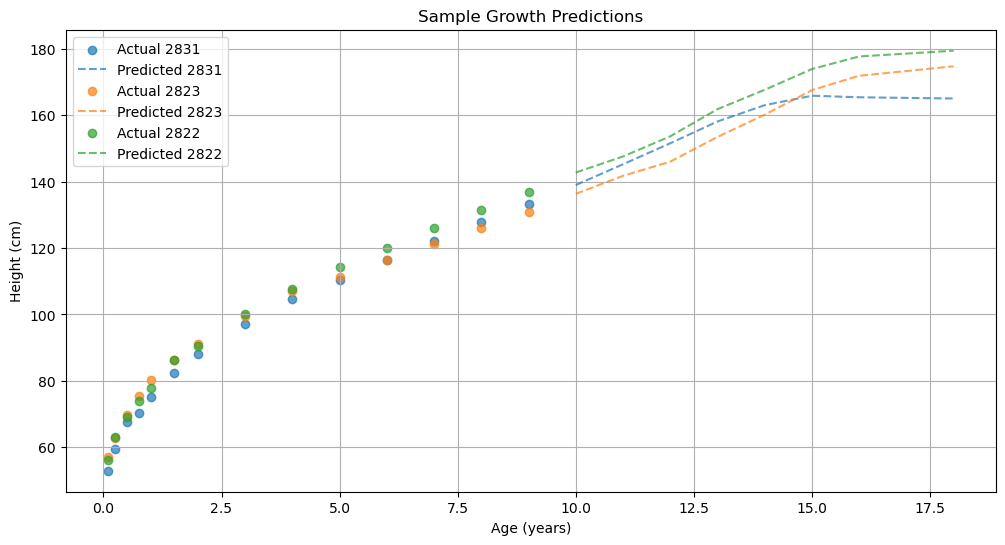

In [21]:
# Plot growth predictions for a sample of gen2 (3 aliens)

plt.figure(figsize=(12, 6))

for gen2_id in predictions['gen2id_age'].str.split('_').str[0].unique()[:3]:
    # Plot actual data
    actual_data = gen2_test[gen2_test['gen2_id'] == int(gen2_id)]
    plt.scatter(actual_data['AgeGr'], actual_data['SHgt_cm'], 
               label=f'Actual {gen2_id}', alpha=0.7)
    
    # Plot predictions
    pred_data = predictions[predictions['gen2id_age'].str.startswith(gen2_id)]
    ages = pred_data['gen2id_age'].str.split('_').str[1].astype(float)
    plt.plot(ages, pred_data['SHgt_cm'], '--', 
            label=f'Predicted {gen2_id}', alpha=0.7)

plt.xlabel('Age (years)')
plt.ylabel('Height (cm)')
plt.title('Sample Growth Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Hereditary Analysis

Defining new feature set with final child height, pubertal growth spurt magnitude and timing

In [22]:
features_list = []

# Process each Gen2 individual
for gen2_id, group in gen2_grouped:
    # Sort by age
    group = group.sort_values('AgeGr')

    # Get parent data if available
    parent_id = group['study_parent_id_new'].iloc[0]
    parent_data = gen1_grouped.get_group(parent_id) if parent_id in gen1_grouped.groups else None

    # Initialize feature dictionary
    features = {'gen2_id': gen2_id}

    # Add child sex
    features['child_sex'] = group['sex_assigned_at_birth'].iloc[0]

    # Compute child growth magnitude (9-15 years)
    height_9 = group[group['AgeGr'] == 9]['SHgt_cm'].mean()
    height_15 = group[group['AgeGr'] == 15]['SHgt_cm'].mean()

    if not np.isnan(height_9) and not np.isnan(height_15):
        features['growth_magnitude_9_15'] = height_15 - height_9
    else:
        features['growth_magnitude_9_15'] = np.nan  # Missing value

    # Get child adult height (last available height)
    features['child_adult_height'] = group['SHgt_cm'].iloc[-1]

    # Compute parent growth velocities if parent data is available
    if parent_data is not None:
        parent_data = parent_data.sort_values('age')
        parent_heights = parent_data['SHgt_cm'].values
        parent_ages = parent_data['age'].values

        # Compute velocities between consecutive age points
        parent_velocities = np.diff(parent_heights) / np.diff(parent_ages)

        # Store velocities with appropriate labels
        for i in range(len(parent_velocities)):
            age_start, age_end = parent_ages[i], parent_ages[i + 1]
            features[f'parent_velocity_{int(age_start)}_{int(age_end)}'] = parent_velocities[i]
        
        features['parent_sex'] = parent_data['sex_assigned_at_birth'].iloc[0]

    # Append features to the list
    features_list.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(features_list)

# Encode child and parent sex
encoder = LabelEncoder()
features_df['child_sex_encoded'] = encoder.fit_transform(features_df['child_sex'])
features_df['parent_sex_encoded'] = encoder.fit_transform(features_df['parent_sex'])

# Handle missing values
features_df.replace(-1, np.nan, inplace=True)
numeric_features = features_df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
features_df[numeric_features] = imputer.fit_transform(features_df[numeric_features])

In [23]:
features_list = []

# Process each Gen2 individual
for gen2_id, group in gen2_grouped:
    # Sort by age
    group = group.sort_values('AgeGr')

    # Get measurements in the 9-15 age range
    puberty_measurements = group[(group['AgeGr'] >= 9) & (group['AgeGr'] <= 15)]

    if len(puberty_measurements) >= 2:
        # Compute growth velocities
        velocities = np.diff(puberty_measurements['SHgt_cm'].values) / np.diff(puberty_measurements['AgeGr'].values)
        velocity_ages = puberty_measurements['AgeGr'].values[1:]  # Age values corresponding to velocities

        # Identify growth spurt onset (first age where velocity is above 90th percentile of pre-puberty)
        threshold = np.percentile(velocities, 90)
        onset_index = np.where(velocities > threshold)[0]
        onset_age = velocity_ages[onset_index[0]] if len(onset_index) > 0 else -1

        # Identify duration (years between onset and velocity drop)
        if onset_age != -1:
            decline_index = np.where(velocities[onset_index[0]:] < threshold / 2)[0]
            end_age = velocity_ages[onset_index[0] + decline_index[0]] if len(decline_index) > 0 else -1
            duration = end_age - onset_age if end_age != -1 else -1
        else:
            duration = -1

    else:
        onset_age = -1
        duration = -1

    # Append to features list
    features = {
        'gen2_id': gen2_id,
        'puberty_onset_age': onset_age,
        'puberty_duration': duration,
    }
    features_list.append(features)

# Convert to DataFrame
puberty_features_df = pd.DataFrame(features_list)

# Merge with the main feature DataFrame
features_df = features_df.merge(puberty_features_df, on='gen2_id', how='left')

# Handle missing values
features_df.replace(-1, np.nan, inplace=True)
numeric_features = features_df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
features_df[numeric_features] = imputer.fit_transform(features_df[numeric_features])

invalid_velocities = [col for col in features_df.columns if "parent_velocity_" in col and col.split("_")[-2] == col.split("_")[-1]]
features_df = features_df.drop(columns=invalid_velocities)

In [24]:
features_df.head()

,gen2_id,child_sex,growth_magnitude_9_15,child_adult_height,parent_velocity_0_1,parent_velocity_1_2,parent_velocity_2_3,parent_velocity_3_4,parent_velocity_4_5,parent_velocity_5_6,...,parent_velocity_15_16,parent_velocity_16_17,parent_velocity_17_18,parent_velocity_18_19,parent_velocity_19_20,parent_sex,child_sex_encoded,parent_sex_encoded,puberty_onset_age,puberty_duration
0,1332.0,F,33.091413,173.976377,15.376466,11.902299,9.583953,7.451248,6.740948,6.105556,...,1.851422,0.982139,0.800961,0.620331,1.36898,NaN,0.0,2.0,13.0,2.0
1,2330.0,F,33.091413,173.976377,15.376466,11.902299,9.583953,7.451248,6.740948,6.105556,...,1.851422,0.982139,0.800961,0.620331,1.36898,NaN,0.0,2.0,13.0,2.0
2,2331.0,M,33.091413,173.976377,15.376466,11.902299,9.583953,7.451248,6.740948,6.105556,...,1.851422,0.982139,0.800961,0.620331,1.36898,NaN,1.0,2.0,13.0,2.0
3,2505.0,F,33.091413,173.976377,15.376466,11.902299,9.583953,7.451248,6.740948,6.105556,...,1.851422,0.982139,0.800961,0.620331,1.36898,NaN,0.0,2.0,13.0,2.0
4,2507.0,F,33.091413,173.976377,15.376466,11.902299,9.583953,7.451248,6.740948,6.105556,...,1.851422,0.982139,0.800961,0.620331,1.36898,NaN,0.0,2.0,13.0,2.0


### (a) Final Height at Adulthood

In [25]:
# Define target and predictors
X = features_df.filter(like='parent_velocity')  # Select all parent velocity features
y = features_df['child_adult_height']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

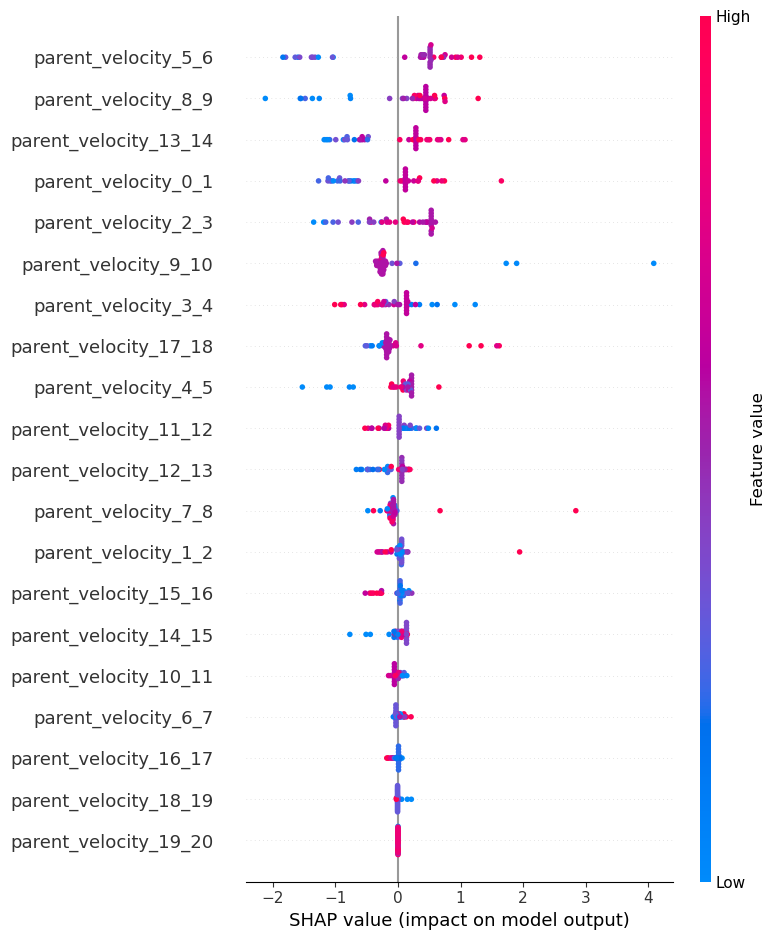

In [26]:
# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)


# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

### (b) Growth Spurt Magnitude

In [27]:
# Define target and predictors
X = features_df[[col for col in features_df.columns if "parent_velocity_" in col 
                 and int(col.split("_")[-2]) < 15 and int(col.split("_")[-1]) < 15]]
y = features_df['growth_magnitude_9_15'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

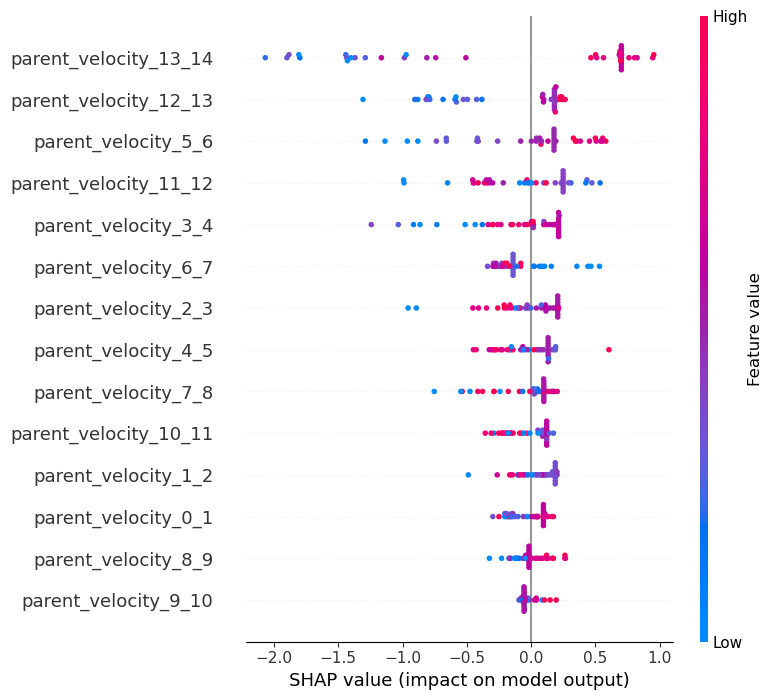

In [28]:
# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)


### (c) Growth Spurt Timing

In [29]:
# Define target and predictors
X = features_df[[col for col in features_df.columns if "parent_velocity_" in col 
                 and int(col.split("_")[-2]) < 15 and int(col.split("_")[-1]) < 15]]
y = features_df['puberty_onset_age'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

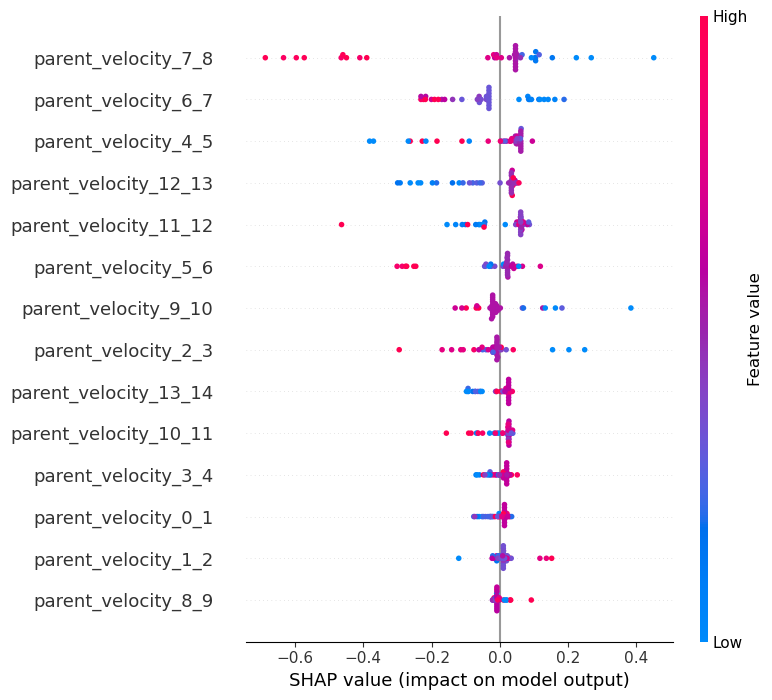

In [30]:
# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)


In [31]:
# Define target and predictors
X = features_df[[col for col in features_df.columns if "parent_velocity_" in col 
                 and int(col.split("_")[-2]) < 15 and int(col.split("_")[-1]) < 15]]
y = features_df['puberty_duration'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

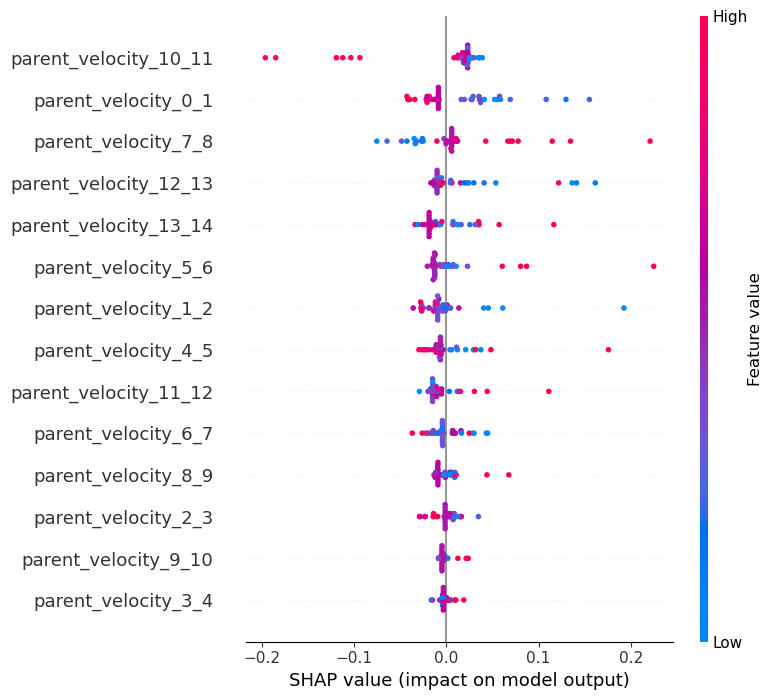

In [32]:
# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

### (d) 

Child F, Parent M: R² = 0.914
Child F, Parent F: R² = 0.724
Child M, Parent M: R² = 0.802
Child M, Parent F: R² = 0.816


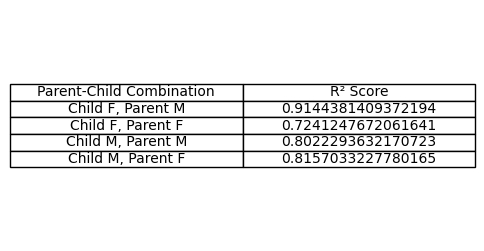

In [33]:
y = features_df['growth_magnitude_9_15'] 

# Store results
results = {}

# Iterate through each parent/child sex combination
for child_sex in features_df['child_sex'].unique():
    for parent_sex in features_df['parent_sex'].unique():
        # Filter dataset for specific sex combination
        subset = features_df[(features_df['child_sex'] == child_sex) & (features_df['parent_sex'] == parent_sex)]
        
        if len(subset) > 10:  # Ensure sufficient data points
            X = subset.filter(like='parent_velocity')  # Use only pre-15 parent velocities
            y_subset = subset['growth_magnitude_9_15'].dropna()
            X = X.loc[y_subset.index]  # Align missing values

            # Train XGBoost model
            xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
            xgb_model.fit(X, y_subset)
            y_pred = xgb_model.predict(X)

            # Compute R² score
            r2 = r2_score(y_subset, y_pred)
            results[f"Child {child_sex}, Parent {parent_sex}"] = r2

# Display results
for group, score in results.items():
    print(f"{group}: R² = {score:.3f}")


# Convert results to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Parent-Child Combination", "R² Score"])

# Create figure and axis for table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=results_df.values, 
                 colLabels=results_df.columns, 
                 cellLoc='center', 
                 loc='center')

plt.show()

Child F, Parent M: R² = 0.593
Child F, Parent F: R² = 0.830
Child M, Parent M: R² = 0.575
Child M, Parent F: R² = 0.911


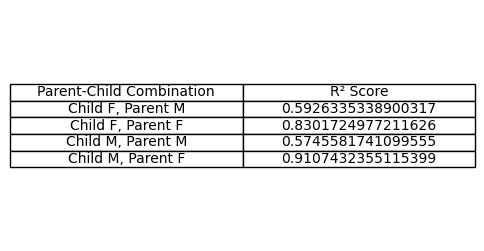

In [34]:
y = features_df['puberty_duration'] 

# Store results
results = {}

# Iterate through each parent/child sex combination
for child_sex in features_df['child_sex'].unique():
    for parent_sex in features_df['parent_sex'].unique():
        # Filter dataset for specific sex combination
        subset = features_df[(features_df['child_sex'] == child_sex) & (features_df['parent_sex'] == parent_sex)]
        
        if len(subset) > 10:  # Ensure sufficient data points
            X = subset.filter(like='parent_velocity')  # Use only pre-15 parent velocities
            y_subset = subset['puberty_duration'].dropna()
            X = X.loc[y_subset.index]  # Align missing values

            # Train XGBoost model
            xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
            xgb_model.fit(X, y_subset)
            y_pred = xgb_model.predict(X)

            # Compute R² score
            r2 = r2_score(y_subset, y_pred)
            results[f"Child {child_sex}, Parent {parent_sex}"] = r2

# Display results
for group, score in results.items():
    print(f"{group}: R² = {score:.3f}")

# Convert results to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Parent-Child Combination", "R² Score"])

# Create figure and axis for table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=results_df.values, 
                 colLabels=results_df.columns, 
                 cellLoc='center', 
                 loc='center')

# Save table as image
plt.show()